# **Kale Combined Model Prediction With Lab**

## Imports and Libraries

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import requests
from io import BytesIO


## Load and Combine Data

### Function to load CSV from Google Drive

In [58]:

def load_csv_from_drive(link):
    response = requests.get(link)
    response.raise_for_status()
    return pd.read_csv(BytesIO(response.content))

### Function to load weight loss data

In [59]:
weight_loss_url = "https://drive.google.com/file/d/1vVIrbfvDaCxjPQu2-V_YC-p6tts2y6qk/view?usp=sharing"
weight_loss_path = 'https://drive.google.com/uc?id=' + weight_loss_url.split('/')[-2]
weight_loss_data = load_csv_from_drive(weight_loss_path)

### Function to load color_data

In [60]:
color_data_urls = [
    "https://drive.google.com/file/d/1z9R40oufp9ozh3trnY1r6qJr3iyboK2I/view?usp=sharing",
    "https://drive.google.com/file/d/1-7YGsaDTGaKEqc4JaxjuiY8JZ4dysspW/view?usp=sharing",
    "https://drive.google.com/file/d/1lLV-m0TCj_FRO5esT6fZbEg2yXpGpIEl/view?usp=sharing",
    "https://drive.google.com/file/d/1FiJIfCxN2xtSj08pVcXrMt5Zrk15JsAG/view?usp=sharing"
]
color_data_paths = ['https://drive.google.com/uc?id=' + url.split('/')[-2] for url in color_data_urls]
color_data = pd.concat([load_csv_from_drive(path) for path in color_data_paths], ignore_index=True)


## Weight Loss Data

### Step 1: Standardize 'Treatment'

In [61]:
weight_loss_data['Treatment'] = weight_loss_data['Treatment'].str.replace('oC', '', regex=False).astype(str).str.strip()
weight_loss_data['Treatment'] = pd.to_numeric(weight_loss_data['Treatment'], errors='coerce')

In [62]:
weight_loss_data.head()

,Treatment,Rep,Percent Weight Loss Day 1,Percent Weight Loss Day 2,Percent Weight Loss Day 3,Percent Weight Loss Day 4,Percent Weight Loss Day 5,Percent Weight Loss Day 6,Percent Weight Loss Day 7,Percent Weight Loss Day 8
0,5,1,2.8,5.8,6.6,7.2,7.4,7.8,8.2,8.9
1,5,2,2.3,5.8,6.4,6.9,7.2,7.6,8.0,8.7
2,5,3,2.6,5.2,6.0,6.6,6.8,7.5,8.0,8.8
3,5,4,2.3,4.2,4.7,5.3,5.6,6.5,7.4,8.0
4,5,5,2.3,3.7,4.6,5.2,5.6,6.3,7.0,7.6


### Step 2: Fill missing values with 100%

In [63]:
numeric_columns = [col for col in weight_loss_data.columns if 'Percent Weight Loss' in col]
weight_loss_data[numeric_columns] = weight_loss_data[numeric_columns]

In [64]:
weight_loss_data.tail()

,Treatment,Rep,Percent Weight Loss Day 1,Percent Weight Loss Day 2,Percent Weight Loss Day 3,Percent Weight Loss Day 4,Percent Weight Loss Day 5,Percent Weight Loss Day 6,Percent Weight Loss Day 7,Percent Weight Loss Day 8
35,20,6,7.0,7.8,11.3,12.7,16.7,32.9,NaN,NaN
36,20,7,5.6,6.7,9.4,11.0,14.5,25.8,NaN,NaN
37,20,8,6.0,6.8,9.8,11.1,14.5,15.8,NaN,NaN
38,20,9,4.7,5.5,8.4,10.1,13.0,21.6,NaN,NaN
39,20,10,4.5,5.9,8.3,9.9,14.0,15.9,NaN,NaN


### Step 3: Visualize weight loss trends

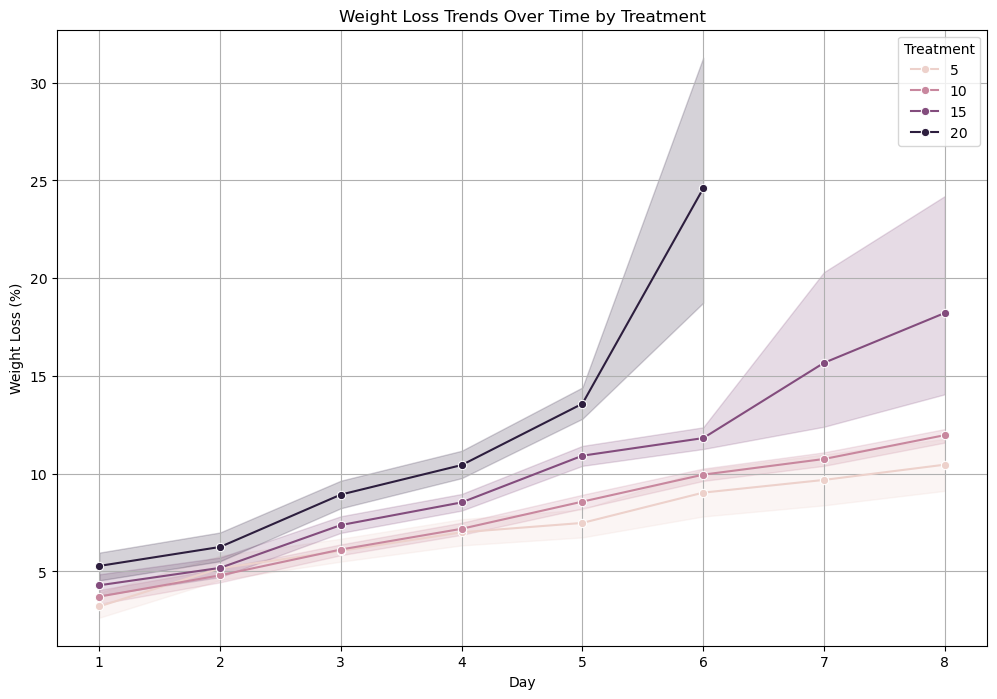

In [65]:
melted_weight_loss = weight_loss_data.melt(
    id_vars=['Treatment', 'Rep'],
    value_vars=numeric_columns,
    var_name='Day',
    value_name='Weight Loss (%)'
)
melted_weight_loss['Day'] = melted_weight_loss['Day'].str.extract(r'(\d+)').astype(int)

plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_weight_loss, x='Day', y='Weight Loss (%)', hue='Treatment', marker='o')
plt.title("Weight Loss Trends Over Time by Treatment")
plt.xlabel("Day")
plt.ylabel("Weight Loss (%)")
plt.grid(True)
plt.legend(title="Treatment")
plt.show()


### Dumpcode -- Predictive Modelling and Training for future

In [12]:
# Step 4: Predictive modeling
X_wl = weight_loss_data[numeric_columns]  # Features: Percent Weight Loss by Day
y_wl = weight_loss_data['Treatment']      # Target: Treatment

# Train-test split
X_train_wl, X_test_wl, y_train_wl, y_test_wl = train_test_split(X_wl, y_wl, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model_wl = RandomForestRegressor(random_state=42)
rf_model_wl.fit(X_train_wl, y_train_wl)

# Make predictions and evaluate
y_pred_wl = rf_model_wl.predict(X_test_wl)
mse_wl = mean_squared_error(y_test_wl, y_pred_wl)
r2_wl = r2_score(y_test_wl, y_pred_wl)

print(f"Weight Loss Model - MSE: {mse_wl}, R²: {r2_wl}")

NameError: name 'numeric_columns' is not defined

## Color Data

### Define function for scaled to hundred

In [66]:
def scale_to_100(series, min_val, max_val):
    return 100 * (series - min_val) / (max_val - min_val)

### Data Clean - Drop Not Matched Pattern Data and NaN Value

In [67]:
# Define the regex pattern
pattern = r"Day(\d+)_(\d+)c_(\d+)-(\d+)\.png"

# Use str.match to check for valid rows that match the pattern
valid_rows = color_data["Filename"].str.match(pattern, na=False)

# Filter the DataFrame to include only valid rows
color_data = color_data[valid_rows]

# Extract values directly from the valid rows
color_data[["Day","Treatment", "Rep", "Leaf"]] = color_data["Filename"].str.extract(pattern).astype(int)

# Display the first 5 rows of the updated DataFrame
color_data.head(5)


,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Treatment,Rep,Leaf
0,41.662500,55.744317,50.639359,65.203040,28.260572,40.842679,17.395628,20.869482,49.328647,62.036708,...,11.126281,14.034042,45.405850,59.382787,1.894643,Day01_5c_1-1.png,1,5,1,1
1,50.385225,65.031697,58.614194,73.258528,38.446959,52.896139,17.932500,21.095128,41.017137,52.075786,...,9.899944,12.447048,53.855003,68.282768,1.925342,Day01_5c_1-2.png,1,5,1,2
2,40.516506,54.558367,48.909531,62.618405,27.189147,41.685244,17.346566,20.685974,51.901231,65.369070,...,10.974666,13.802485,43.924553,57.518459,1.885451,Day01_5c_1-3.png,1,5,1,3
3,48.563244,60.445238,56.791366,68.284997,37.094062,49.357088,19.286972,21.474042,43.644147,52.333638,...,9.790466,11.829570,52.086038,63.590692,1.916725,Day01_5c_1-4.png,1,5,1,4
4,45.960128,63.624433,53.766259,71.935755,34.128363,50.444078,16.174544,20.618591,39.062434,52.941864,...,9.639012,13.039988,49.194334,66.785039,1.920758,Day01_5c_1-5.png,1,5,1,5


In [68]:
color_data.to_csv('color_data.csv', index=False)

In [69]:
rgb_columns = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean']
lab_columns = ['Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean']
hsv_columns = ['HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean']

### Graph Plotting - Lab*

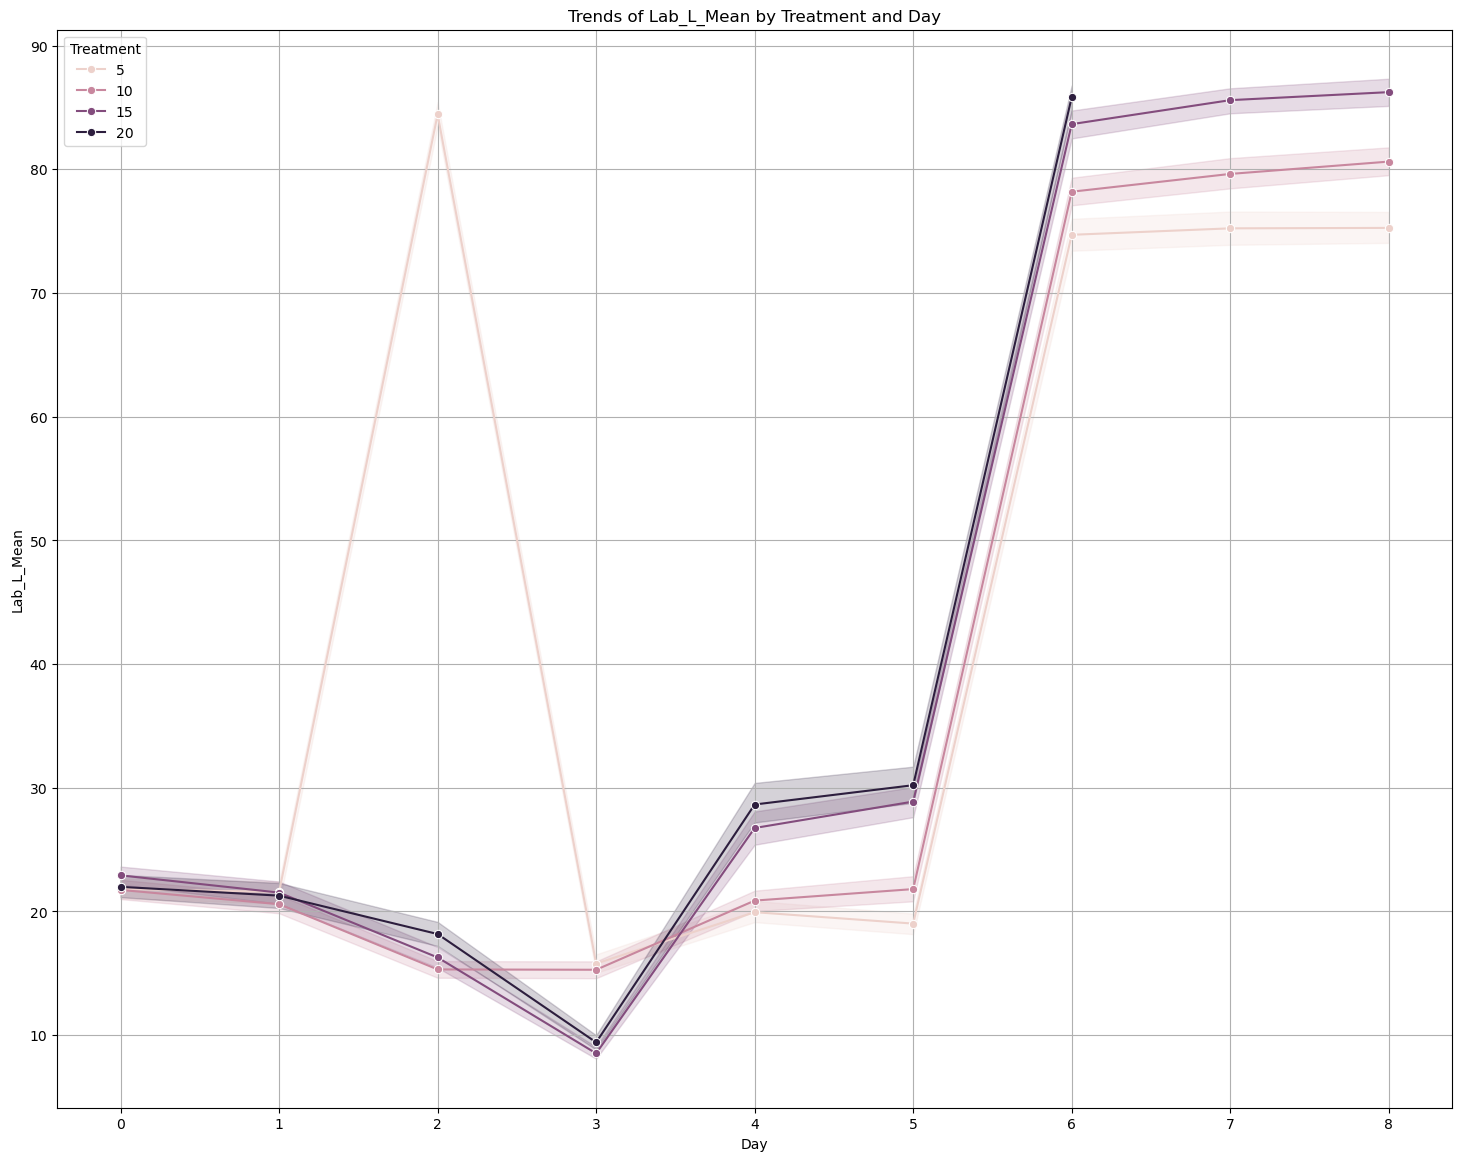

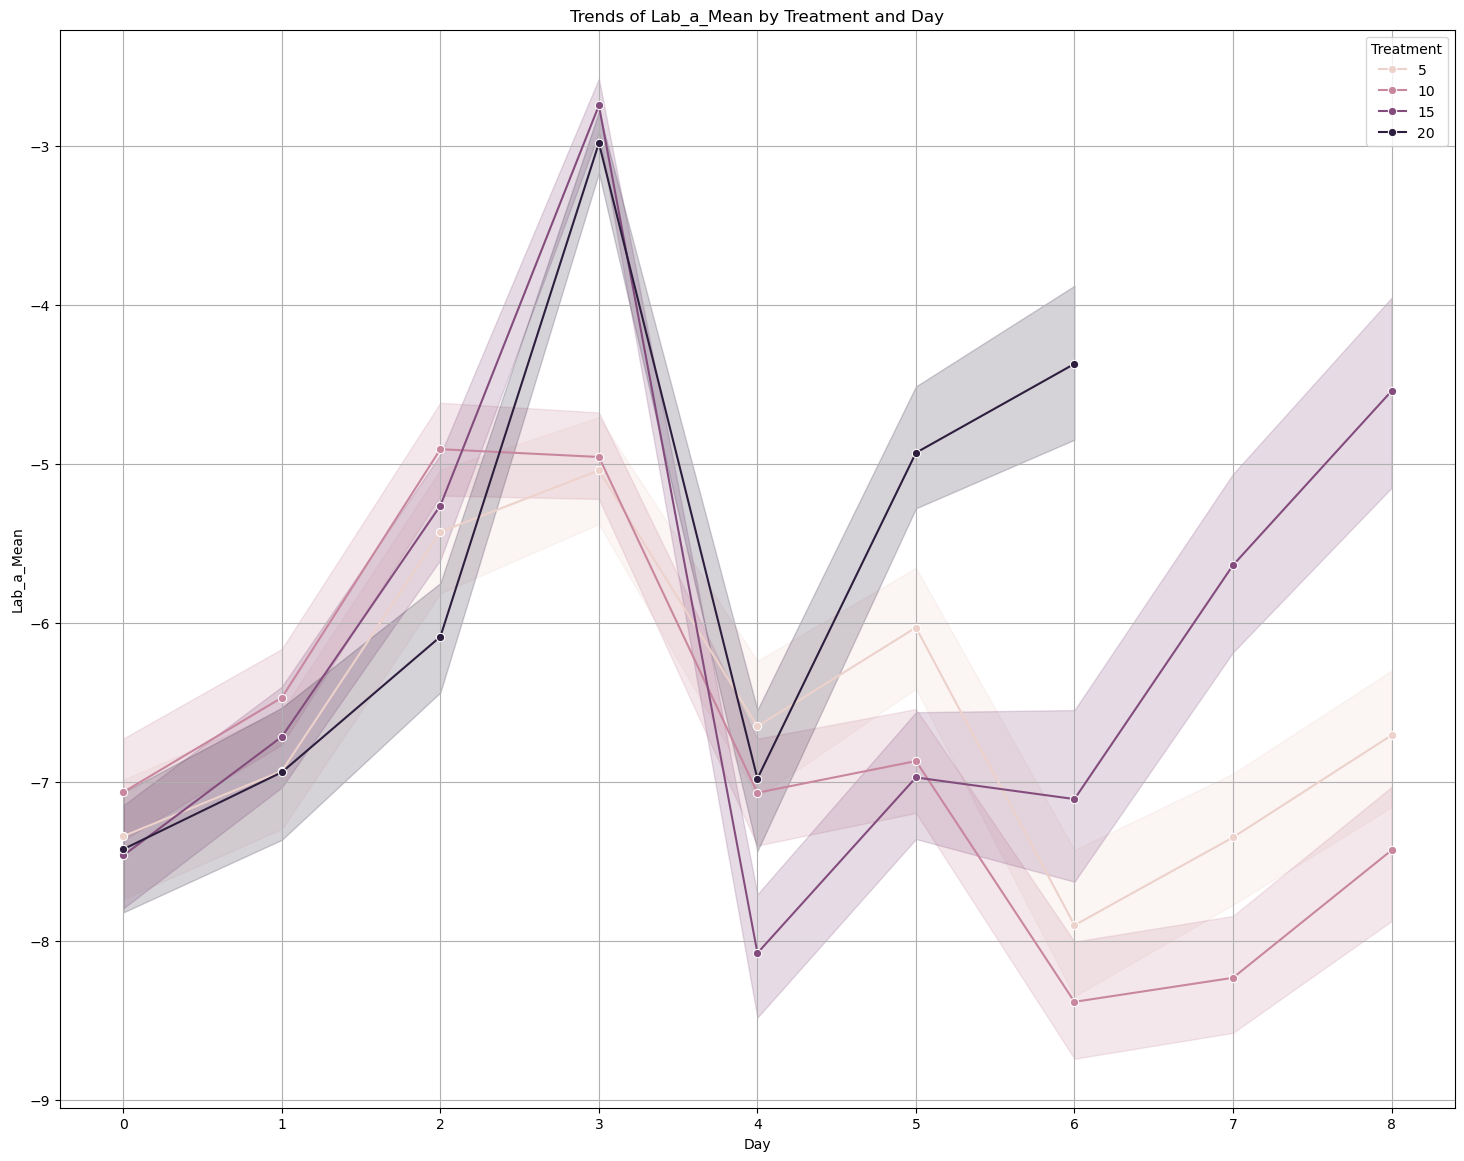

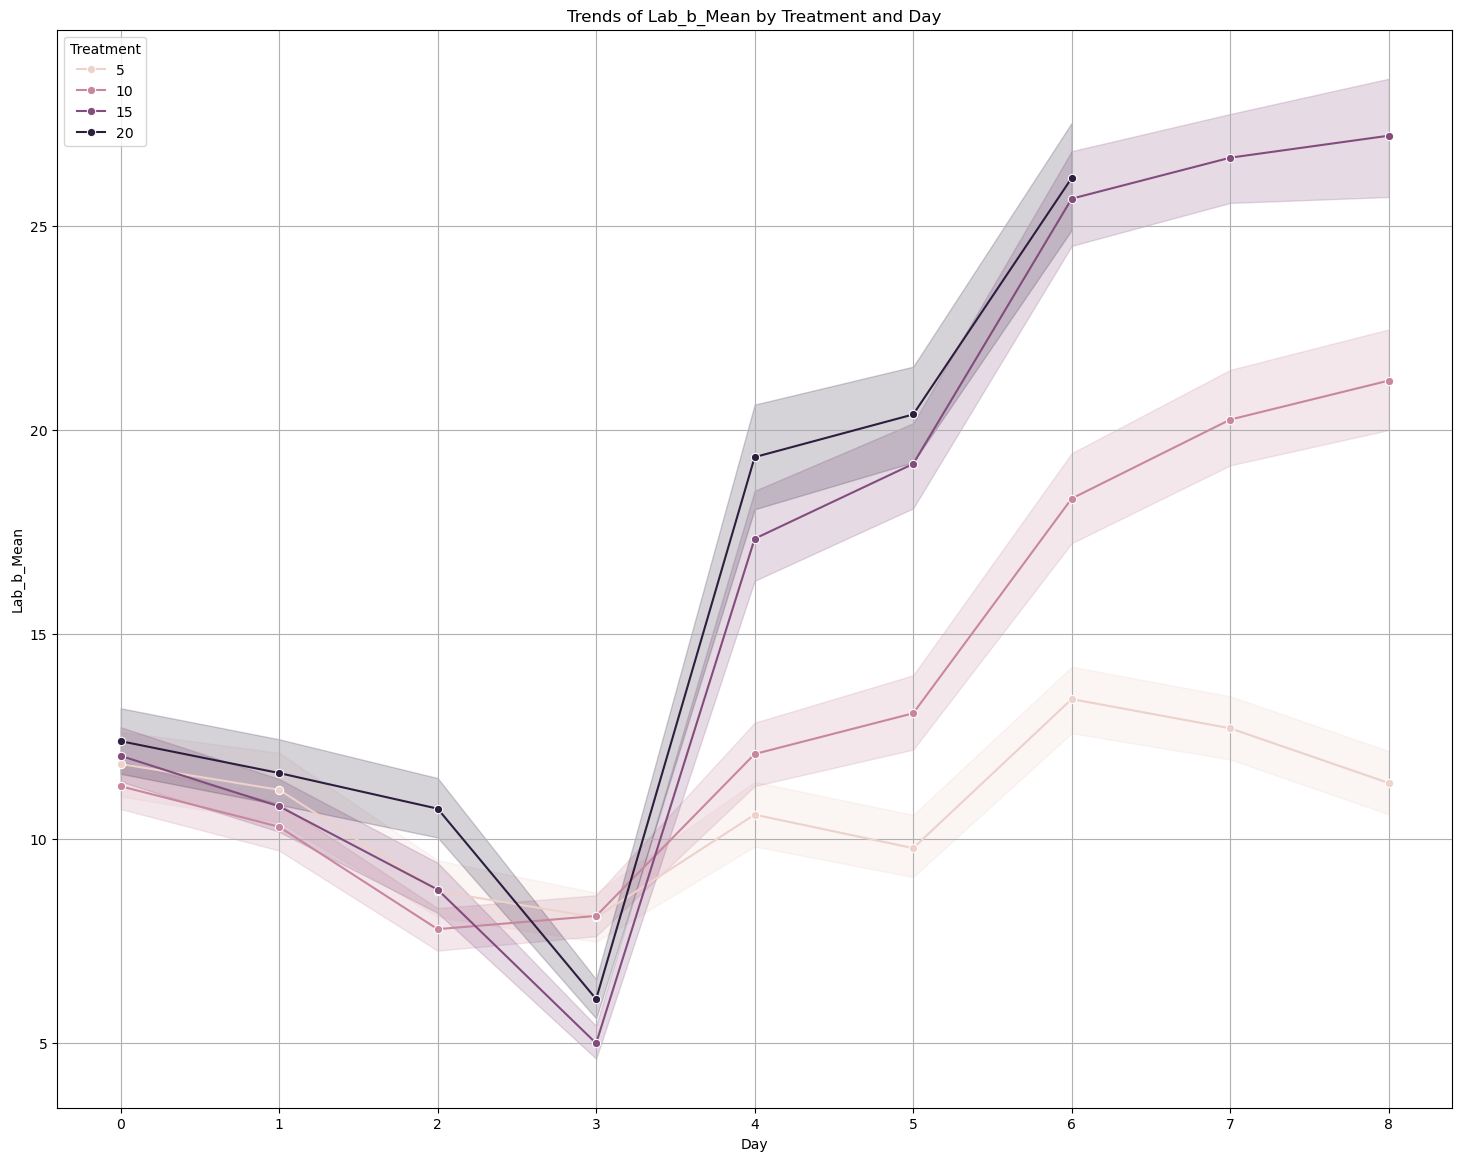

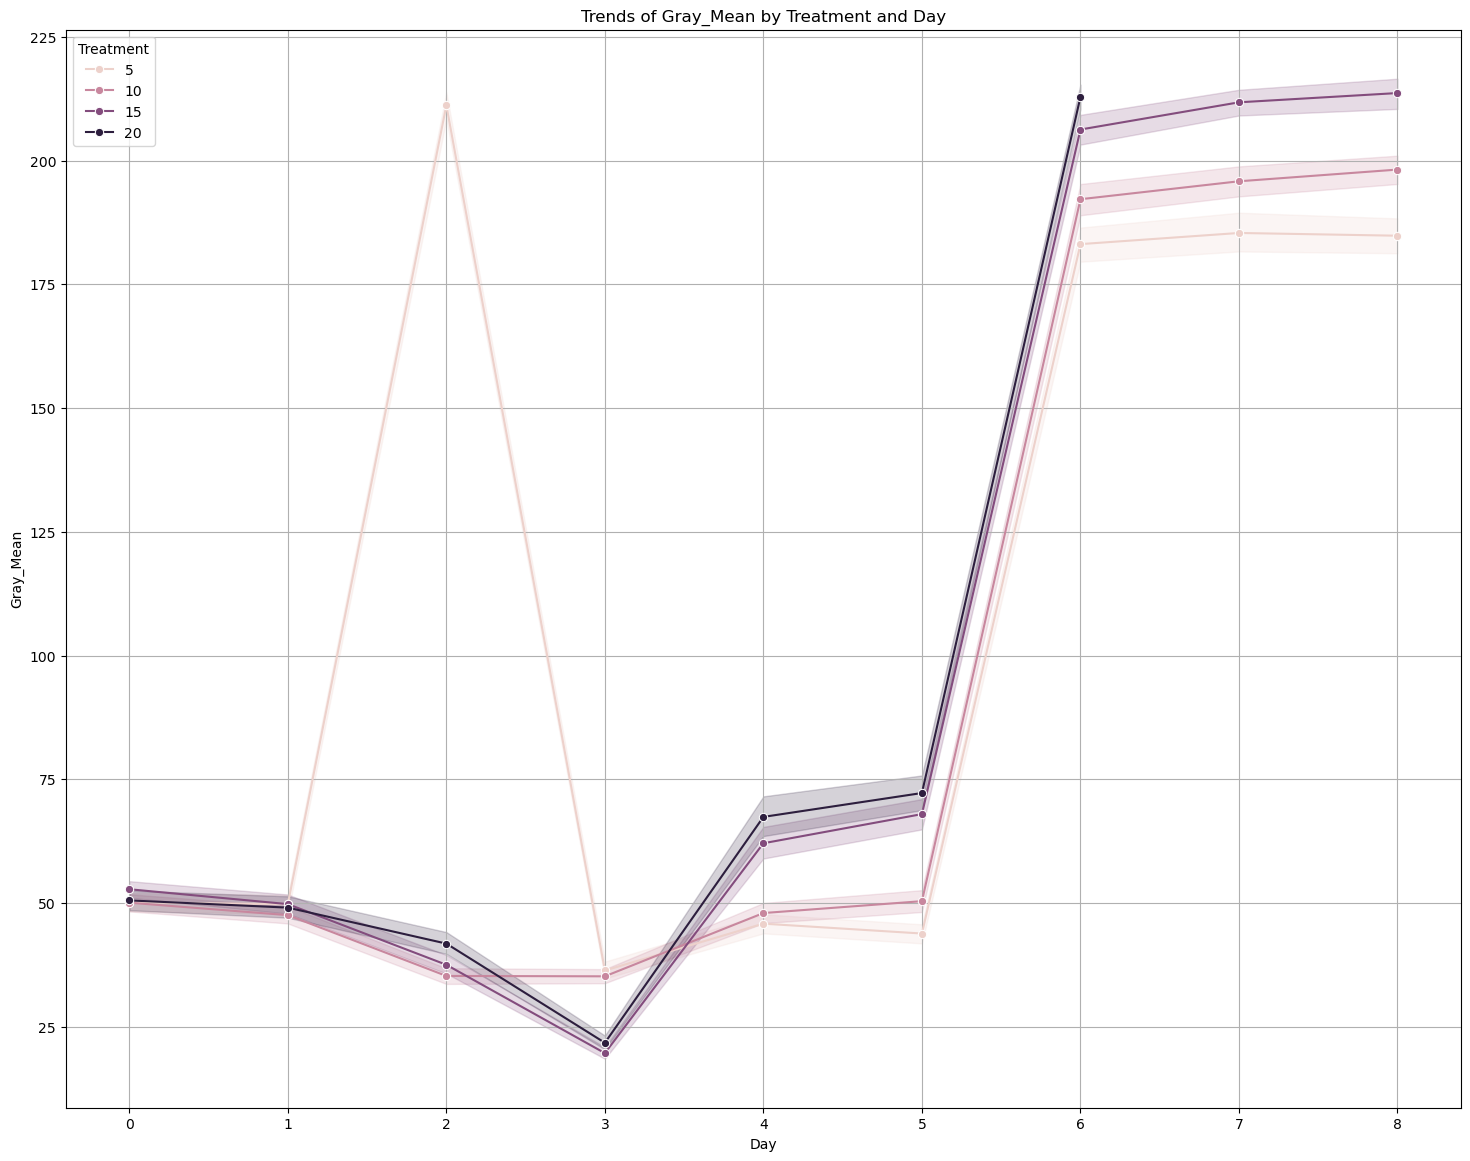

In [70]:
# Plot all graphs for LAB and Gray mean
lab_gray_columns = lab_columns + ['Gray_Mean']

for col in lab_gray_columns:
    plt.figure(figsize=(18, 14))
    sns.lineplot(data=color_data, x='Day', y=col, hue='Treatment', marker='o')
    plt.title(f"Trends of {col} by Treatment and Day")
    plt.xlabel("Day")
    plt.ylabel(col)
    plt.grid(True)
    plt.legend(title="Treatment")
    plt.show()

### Scaled All Color Data to 0,100

#### Scaled RGB

In [16]:
for col in rgb_columns:
    if col in color_data.columns:
        color_data[col] = scale_to_100(color_data[col], 0, 255)

In [ ]:
color_data.head()

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Treatment,Rep,Leaf
0,16.338235,55.744317,19.858572,65.203040,11.082577,40.842679,17.395628,20.869482,49.328647,62.036708,...,11.126281,14.034042,45.405850,59.382787,1.894643,Day01_5c_1-1.png,1,5,1,1
1,19.758912,65.031697,22.985958,73.258528,15.077239,52.896139,17.932500,21.095128,41.017137,52.075786,...,9.899944,12.447048,53.855003,68.282768,1.925342,Day01_5c_1-2.png,1,5,1,2
2,15.888826,54.558367,19.180208,62.618405,10.662411,41.685244,17.346566,20.685974,51.901231,65.369070,...,10.974666,13.802485,43.924553,57.518459,1.885451,Day01_5c_1-3.png,1,5,1,3
3,19.044409,60.445238,22.271124,68.284997,14.546691,49.357088,19.286972,21.474042,43.644147,52.333638,...,9.790466,11.829570,52.086038,63.590692,1.916725,Day01_5c_1-4.png,1,5,1,4
4,18.023580,63.624433,21.084808,71.935755,13.383672,50.444078,16.174544,20.618591,39.062434,52.941864,...,9.639012,13.039988,49.194334,66.785039,1.920758,Day01_5c_1-5.png,1,5,1,5


#### Scaled HSV

In [18]:

for col in hsv_columns:
    if col == 'HSV_H_Mean':  # Hue is in the range 0-360
        color_data[col] = scale_to_100(color_data[col], 0, 360)
    elif col in color_data.columns:  # Saturation and Value are in the range 0-100
        color_data[col] = scale_to_100(color_data[col], 0, 100)

In [19]:
color_data.head()

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Treatment,Rep,Leaf
0,16.338235,55.744317,19.858572,65.203040,11.082577,40.842679,4.832119,20.869482,49.328647,62.036708,...,11.126281,14.034042,45.405850,59.382787,1.894643,Day01_5c_1-1.png,1,5,1,1
1,19.758912,65.031697,22.985958,73.258528,15.077239,52.896139,4.981250,21.095128,41.017137,52.075786,...,9.899944,12.447048,53.855003,68.282768,1.925342,Day01_5c_1-2.png,1,5,1,2
2,15.888826,54.558367,19.180208,62.618405,10.662411,41.685244,4.818490,20.685974,51.901231,65.369070,...,10.974666,13.802485,43.924553,57.518459,1.885451,Day01_5c_1-3.png,1,5,1,3
3,19.044409,60.445238,22.271124,68.284997,14.546691,49.357088,5.357492,21.474042,43.644147,52.333638,...,9.790466,11.829570,52.086038,63.590692,1.916725,Day01_5c_1-4.png,1,5,1,4
4,18.023580,63.624433,21.084808,71.935755,13.383672,50.444078,4.492929,20.618591,39.062434,52.941864,...,9.639012,13.039988,49.194334,66.785039,1.920758,Day01_5c_1-5.png,1,5,1,5


#### Scaled Lab

In [20]:

for col in lab_columns:
    if col == 'Lab_L_Mean':  # L* is in the range 0-100
        color_data[col] = scale_to_100(color_data[col], 0, 100)
    elif col in color_data.columns:  # a* and b* are in the range -128 to 127
        color_data[col] = scale_to_100(color_data[col], -128, 127)

In [21]:
color_data.head()

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Treatment,Rep,Leaf
0,16.338235,55.744317,19.858572,65.203040,11.082577,40.842679,4.832119,20.869482,49.328647,62.036708,...,54.559326,14.034042,45.405850,59.382787,1.894643,Day01_5c_1-1.png,1,5,1,1
1,19.758912,65.031697,22.985958,73.258528,15.077239,52.896139,4.981250,21.095128,41.017137,52.075786,...,54.078409,12.447048,53.855003,68.282768,1.925342,Day01_5c_1-2.png,1,5,1,2
2,15.888826,54.558367,19.180208,62.618405,10.662411,41.685244,4.818490,20.685974,51.901231,65.369070,...,54.499869,13.802485,43.924553,57.518459,1.885451,Day01_5c_1-3.png,1,5,1,3
3,19.044409,60.445238,22.271124,68.284997,14.546691,49.357088,5.357492,21.474042,43.644147,52.333638,...,54.035477,11.829570,52.086038,63.590692,1.916725,Day01_5c_1-4.png,1,5,1,4
4,18.023580,63.624433,21.084808,71.935755,13.383672,50.444078,4.492929,20.618591,39.062434,52.941864,...,53.976083,13.039988,49.194334,66.785039,1.920758,Day01_5c_1-5.png,1,5,1,5


#### Scaled Gray

In [22]:
if 'Gray_Mean' in color_data.columns:
    color_data['Gray_Mean'] = scale_to_100(color_data['Gray_Mean'], 0, 255)

In [23]:
color_data.head()

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Treatment,Rep,Leaf
0,16.338235,55.744317,19.858572,65.203040,11.082577,40.842679,4.832119,20.869482,49.328647,62.036708,...,54.559326,14.034042,17.806216,59.382787,1.894643,Day01_5c_1-1.png,1,5,1,1
1,19.758912,65.031697,22.985958,73.258528,15.077239,52.896139,4.981250,21.095128,41.017137,52.075786,...,54.078409,12.447048,21.119609,68.282768,1.925342,Day01_5c_1-2.png,1,5,1,2
2,15.888826,54.558367,19.180208,62.618405,10.662411,41.685244,4.818490,20.685974,51.901231,65.369070,...,54.499869,13.802485,17.225315,57.518459,1.885451,Day01_5c_1-3.png,1,5,1,3
3,19.044409,60.445238,22.271124,68.284997,14.546691,49.357088,5.357492,21.474042,43.644147,52.333638,...,54.035477,11.829570,20.425897,63.590692,1.916725,Day01_5c_1-4.png,1,5,1,4
4,18.023580,63.624433,21.084808,71.935755,13.383672,50.444078,4.492929,20.618591,39.062434,52.941864,...,53.976083,13.039988,19.291896,66.785039,1.920758,Day01_5c_1-5.png,1,5,1,5


In [75]:
color_data[lab_columns]

,Lab_L_Mean,Lab_a_Mean,Lab_b_Mean
0,19.913371,-7.325000,11.126281
1,23.144604,-6.666106,9.899944
2,19.289196,-7.049141,10.974666
3,22.498678,-6.687475,9.790466
4,21.209158,-6.370637,9.639012
...,...,...,...
2064,29.756467,-10.402456,17.800909
2065,29.267489,-10.006966,17.955012
2066,20.200283,-7.312031,11.720566
2067,20.167047,-6.661634,10.934753


### Dump Section

File 1z9R40oufp9ozh3trnY1r6qJr3iyboK2I has been downloaded and read successfully
File 1-7YGsaDTGaKEqc4JaxjuiY8JZ4dysspW has been downloaded and read successfully
File 1lLV-m0TCj_FRO5esT6fZbEg2yXpGpIEl has been downloaded and read successfully
File 1FiJIfCxN2xtSj08pVcXrMt5Zrk15JsAG has been downloaded and read successfully
All data has been successfully combined


<ipython-input-52-303848fc41e9>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  color_data['Temperature'] = color_data['Filename'].str.extract(r'_(\d+c)_')[0].replace({'5c': 5, '10c': 10, '15c': 15, '20c': 20}).fillna(0).astype(float)


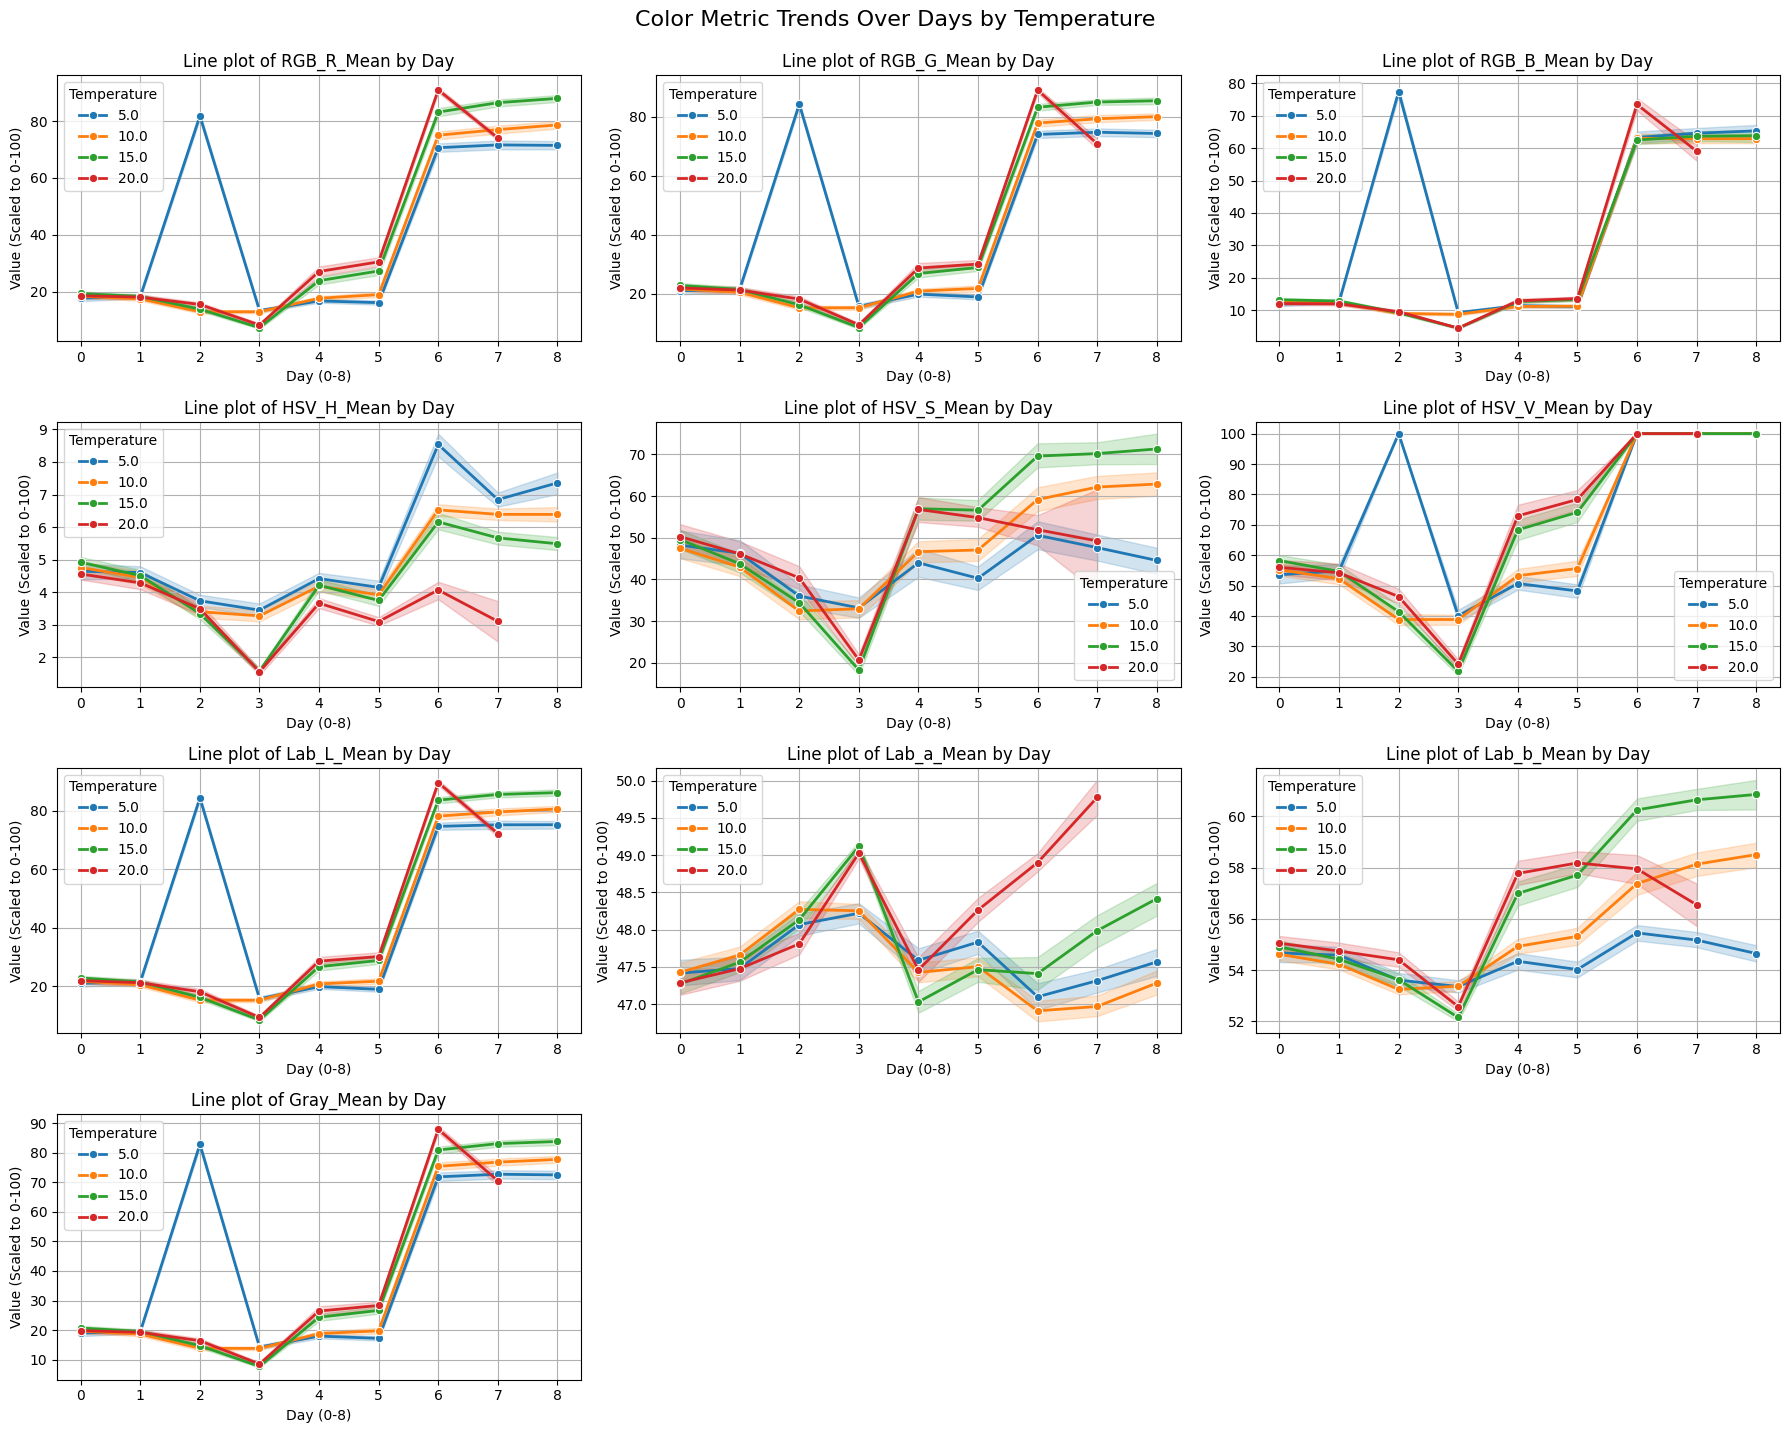

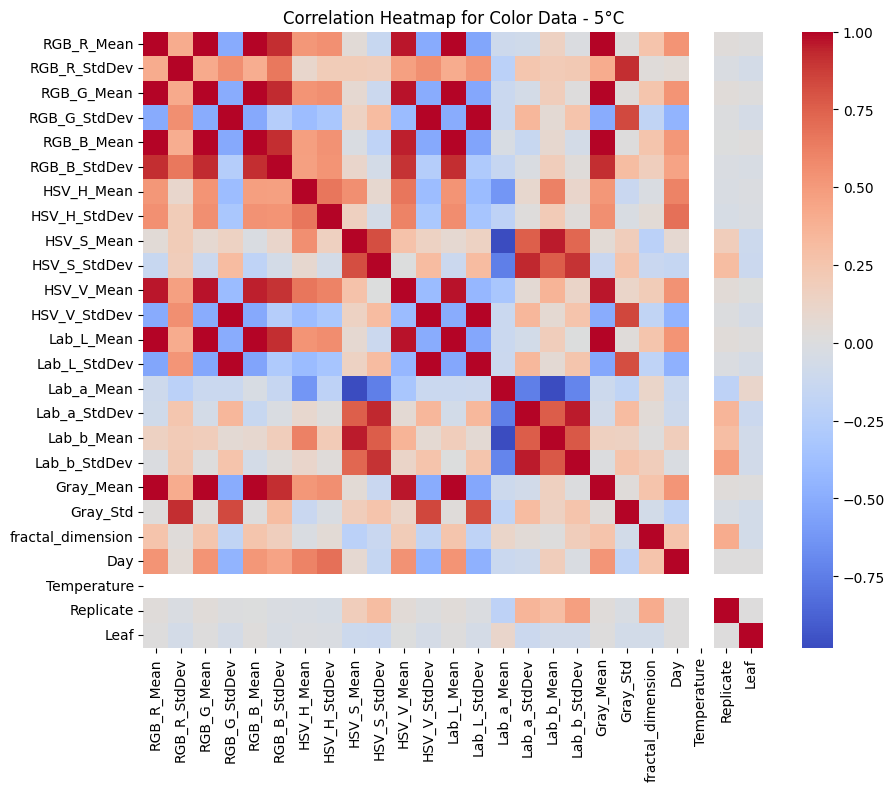

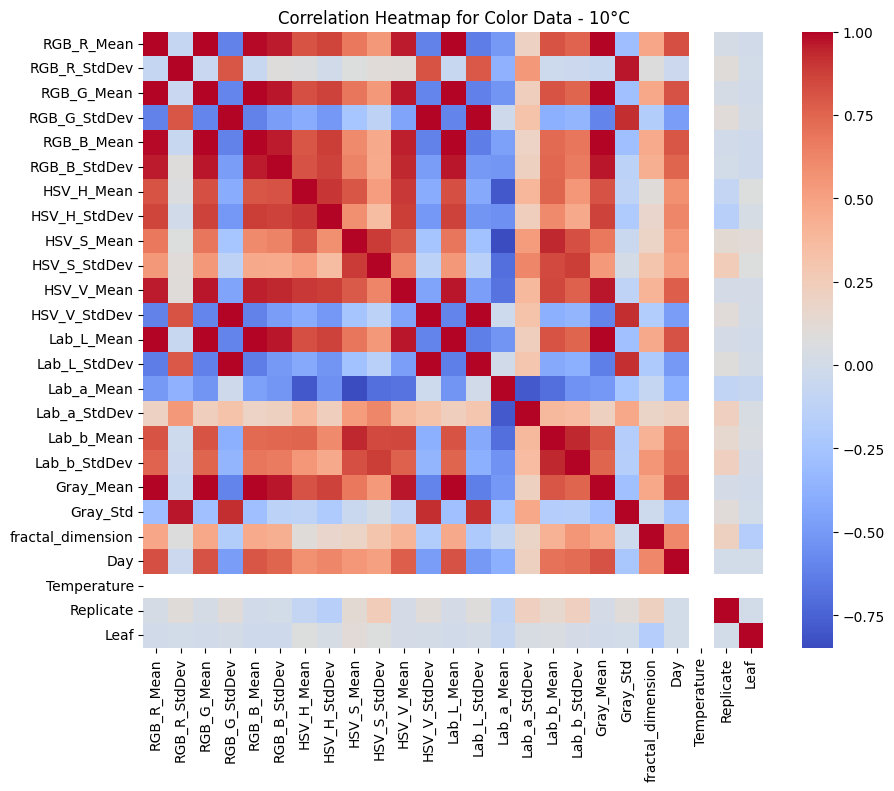

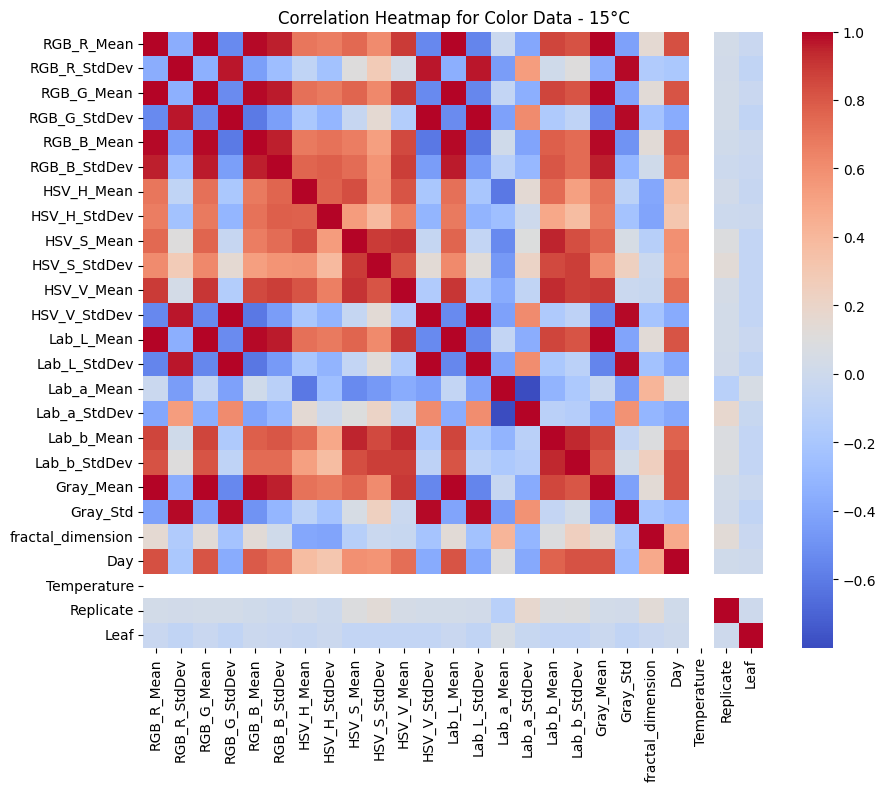

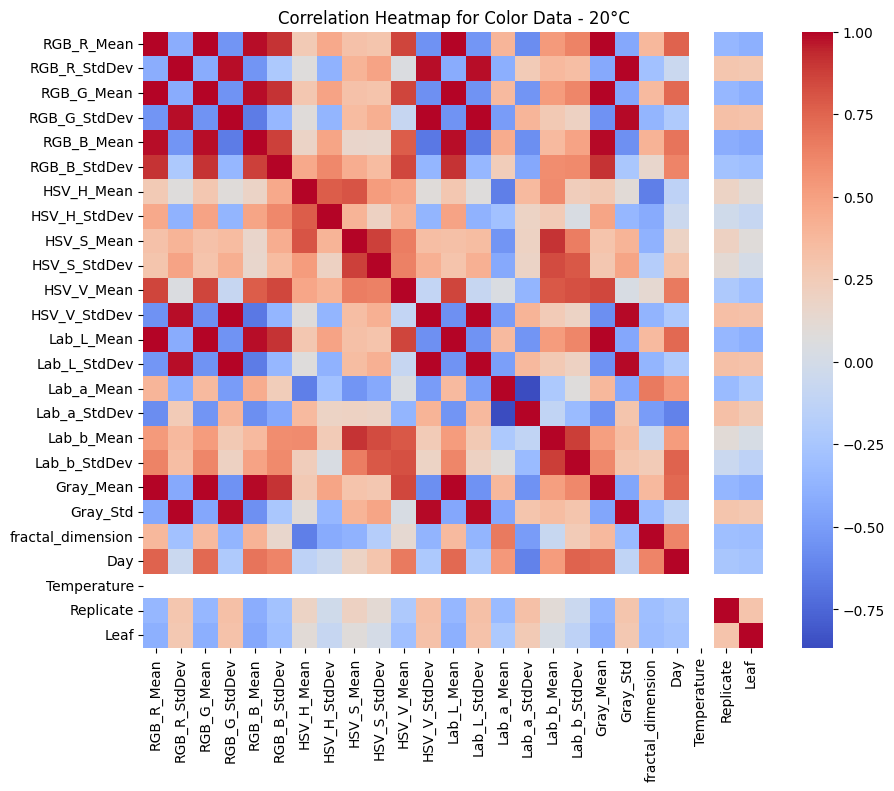

   Day  Temperature      Metric      Value
0  1.0          5.0  RGB_R_Mean  16.338235
1  1.0          5.0  RGB_R_Mean  19.758912
2  1.0          5.0  RGB_R_Mean  15.888826
3  1.0          5.0  RGB_R_Mean  19.044409
4  1.0          5.0  RGB_R_Mean  18.023580


In [ ]:
# Function to scale values to the range of 0-100
def scale_to_100(series, min_val, max_val):
    return ((series - min_val) / (max_val - min_val)) * 100

# List of file_ids
file_ids = [
    "1z9R40oufp9ozh3trnY1r6qJr3iyboK2I",
    "1-7YGsaDTGaKEqc4JaxjuiY8JZ4dysspW",
    "1lLV-m0TCj_FRO5esT6fZbEg2yXpGpIEl",
    "1FiJIfCxN2xtSj08pVcXrMt5Zrk15JsAG"
]

# Read and combine data from all files
all_data = []
for file_id in file_ids:
    download_url = f"https://drive.google.com/uc?id={file_id}&export=download"
    try:
        data = pd.read_csv(download_url)
        print(f"File {file_id} has been downloaded and read successfully")
        all_data.append(data)
    except Exception as e:
        print(f"Error occurred while downloading file {file_id}: {e}")

# Combine all data together
if all_data:
    color_data = pd.concat(all_data, ignore_index=True)
    print("All data has been successfully combined")

    # Check if 'Filename' column exists
    if 'Filename' in color_data.columns:
        color_data['Filename'] = color_data['Filename'].astype(str)

        # Extract data from Filename
        color_data['Day'] = color_data['Filename'].str.extract(r'(Day\d+)')[0].str.replace('Day', '', regex=False).fillna(0).astype(int)
        color_data['Temperature'] = color_data['Filename'].str.extract(r'_(\d+c)_')[0].replace({'5c': 5, '10c': 10, '15c': 15, '20c': 20}).fillna(0).astype(float)
        color_data['Replicate'] = color_data['Filename'].str.extract(r'_(\d+)-')[0].fillna(0).astype(float)
        color_data['Leaf'] = color_data['Filename'].str.extract(r'-(\d+)\.')[0].fillna(0).astype(float)

    # Scale RGB values to range 0-100
    rgb_columns = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean']
    for col in rgb_columns:
        if col in color_data.columns:
            color_data[col] = scale_to_100(color_data[col], 0, 255)

    # Scale HSV values to range 0-100
    hsv_columns = ['HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean']
    for col in hsv_columns:
        if col == 'HSV_H_Mean':  # Hue is in the range 0-360
            color_data[col] = scale_to_100(color_data[col], 0, 360)
        elif col in color_data.columns:  # Saturation and Value are in the range 0-100
            color_data[col] = scale_to_100(color_data[col], 0, 100)

    # Scale Lab values to range 0-100
    lab_columns = ['Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean']
    for col in lab_columns:
        if col == 'Lab_L_Mean':  # L* is in the range 0-100
            color_data[col] = scale_to_100(color_data[col], 0, 100)
        elif col in color_data.columns:  # a* and b* are in the range -128 to 127
            color_data[col] = scale_to_100(color_data[col], -128, 127)

    # Scale Gray values to range 0-100
    if 'Gray_Mean' in color_data.columns:
        color_data['Gray_Mean'] = scale_to_100(color_data['Gray_Mean'], 0, 255)

    # Handle missing values
    numeric_columns_color = color_data.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    color_data[numeric_columns_color] = imputer.fit_transform(color_data[numeric_columns_color])

    # Filter out values exceeding 100
    color_data[numeric_columns_color] = color_data[numeric_columns_color].apply(lambda x: np.minimum(x, 100))

    # Plot the data for each metric grouped by Day
    plt.figure(figsize=(18, 14))
    color_metrics = rgb_columns + hsv_columns + lab_columns + ['Gray_Mean']

    # Plot line plot for each metric across Days (0 to 8)
    for i, metric in enumerate(color_metrics):
        plt.subplot(4, 3, i + 1)  # Create a grid of 4 rows x 3 columns
        sns.lineplot(data=color_data, x='Day', y=metric, hue='Temperature', marker='o', palette='tab10', linewidth=2)
        plt.title(f"Line plot of {metric} by Day")
        plt.xlabel("Day (0-8)")
        plt.ylabel("Value (Scaled to 0-100)")
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle("Color Metric Trends Over Days by Temperature", fontsize=16, y=1.02)
    plt.show()

    # Handle missing values and compute correlations by temperature
    correlation_by_temperature = {}
    for temp in sorted(color_data['Temperature'].unique()):
        temp_data = color_data[color_data['Temperature'] == temp]
        correlation_by_temperature[temp] = temp_data[numeric_columns_color].corr()

        # Visualize correlation matrix for each temperature
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_by_temperature[temp], annot=False, cmap='coolwarm', fmt='.2f')
        plt.title(f"Correlation Heatmap for Color Data - {int(temp)}°C")
        plt.show()

    # Melt the data to create trend charts for color metrics by day and treatment
    color_metrics = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean', 'HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean',
                     'Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean']

    # Melt data for visualization
    melted_color_data = color_data.melt(
        id_vars=['Day', 'Temperature'],
        value_vars=color_metrics,
        var_name='Metric',
        value_name='Value'
    )
    print(melted_color_data.head())  # Optional: to check the melted data

else:
    print("Unable to combine data because no files were successfully read")


In [27]:
import pandas as pd
import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Google Drive URLs
weight_loss_url = "https://drive.google.com/file/d/1vVIrbfvDaCxjPQu2-V_YC-p6tts2y6qk/view?usp=sharing"
color_data_urls = [
    "https://drive.google.com/file/d/1z9R40oufp9ozh3trnY1r6qJr3iyboK2I/view?usp=sharing",
    "https://drive.google.com/file/d/1-7YGsaDTGaKEqc4JaxjuiY8JZ4dysspW/view?usp=sharing",
    "https://drive.google.com/file/d/1lLV-m0TCj_FRO5esT6fZbEg2yXpGpIEl/view?usp=sharing",
    "https://drive.google.com/file/d/1FiJIfCxN2xtSj08pVcXrMt5Zrk15JsAG/view?usp=sharing"
]

# Convert Google Drive URLs to direct download links
weight_loss_path = 'https://drive.google.com/uc?id=' + weight_loss_url.split('/')[-2]
color_data_paths = ['https://drive.google.com/uc?id=' + url.split('/')[-2] for url in color_data_urls]

# Function to load CSV from Google Drive
def load_csv_from_drive(link):
    response = requests.get(link)
    response.raise_for_status()
    return pd.read_csv(BytesIO(response.content))

# Load weight loss data
weight_loss_data = load_csv_from_drive(weight_loss_path)

# Load and combine color data
color_data = pd.concat([load_csv_from_drive(path) for path in color_data_paths], ignore_index=True)

# Standardize 'Treatment' in weight loss data (e.g., convert "5oC" to 5)
weight_loss_data['Treatment'] = weight_loss_data['Treatment'].str.replace('oC', '', regex=False).astype(float)

# Melt weight loss data to long format
wl_melted = weight_loss_data.melt(
    id_vars=['Treatment', 'Rep'],
    value_vars=[col for col in weight_loss_data.columns if 'Percent Weight Loss' in col],
    var_name='Day',
    value_name='Weight Loss (%)'
)
wl_melted['Day'] = wl_melted['Day'].str.extract(r'(\d+)').astype(int)

# Parse 'Filename' column into components in color data
if 'Filename' in color_data.columns:
    color_data['Filename'] = color_data['Filename'].astype(str)

    # Identify invalid rows
    valid_rows = color_data['Filename'].str.extract(r'(Day\d+)')[0].notnull()
    color_data = color_data.loc[valid_rows]

    # Parse components
    color_data['Day'] = (
        color_data['Filename'].str.extract(r'(Day\d+)')[0]
        .str.replace('Day', '', regex=False)
        .astype(int)
    )
    color_data['Temperature'] = (
        color_data['Filename'].str.extract(r'_(\d+c)_')[0]
        .replace({'5c': 5, '10c': 10, '15c': 15, '20c': 20})
        .astype(float)
    )
    color_data['Replicate'] = color_data['Filename'].str.extract(r'_(\d+)-')[0].astype(float)
    color_data['Leaf'] = color_data['Filename'].str.extract(r'-(\d+)\.')[0].astype(float)

# Handle missing values in numeric columns
numeric_columns_color = color_data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
color_data[numeric_columns_color] = imputer.fit_transform(color_data[numeric_columns_color])
numeric_columns_color
# Add 'Treatment' to match with weight loss data
color_data['Treatment'] = color_data['Temperature']

# Merge weight loss and color data on 'Day' and 'Treatment'
combined_data = pd.merge(color_data, wl_melted, on=['Day', 'Treatment'], how='left')

# Compute correlation matrix for numeric columns
combined_correlation = combined_data.select_dtypes(include=['float64', 'int64']).corr()

# Filter correlations between color metrics and weight loss
color_metrics = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean',
                 'HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean',
                 'Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean',
                 'Gray_Mean', 'fractal_dimension']
wl_columns = ['Weight Loss (%)']

# Extract relevant correlations
color_wl_correlation = combined_correlation.loc[color_metrics, wl_columns]

# Visualize the combined correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(combined_correlation, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap for Combined Color and Weight Loss Data")
plt.show()

# Display specific correlations between color metrics and weight loss
plt.figure(figsize=(10, 8))
sns.heatmap(color_wl_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Color Metrics and Weight Loss")
plt.show()

# Melt the data for visualization of trends by temperature (after merging)
melted_color_data = combined_data.melt(
    id_vars=['Day', 'Temperature'],
    value_vars=['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean',
                'HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean',
                'Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean',
                'Gray_Mean', 'fractal_dimension', 'Weight Loss (%)'],
    var_name='Metric',
    value_name='Value'
)

# Clip the values to ensure they don't exceed 100
melted_color_data['Value'] = melted_color_data['Value'].clip(upper=100)

# Plot trends for each color metric by temperature with clearer markers and thicker lines
plt.figure(figsize=(14, 10))

# Define a more suitable list of markers for each metric
markers = ['o', 's', 'D', '^', 'P', 'H', 'X', 'v', '<', '>', '8', 'p']  # 12 markers for 12 metrics

# Plot the lineplot with customized markers and weights
sns.lineplot(data=melted_color_data, x='Day', y='Value', hue='Temperature',
             style='Metric', markers=markers, linewidth=2, ci=None)

# Add titles and labels
plt.title("Trends in Color Metrics and Weight Loss by Day and Temperature", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)

# Customize legend
plt.legend(title="Temperature (°C)", loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Adjust the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_25620\3298753462.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'5c': 5, '10c': 10, '15c': 15, '20c': 20})


In [ ]:
color_data

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension,Filename,Day,Temperature,Replicate,Leaf
0,41.662500,55.744317,50.639359,65.203040,28.260572,40.842679,17.395628,20.869482,49.328647,62.036708,...,11.126281,14.034042,45.405850,59.382787,1.894643,Day01_5c_1-1.png,1,5.0,1.0,1.0
1,50.385225,65.031697,58.614194,73.258528,38.446959,52.896139,17.932500,21.095128,41.017137,52.075786,...,9.899944,12.447048,53.855003,68.282768,1.925342,Day01_5c_1-2.png,1,5.0,1.0,2.0
2,40.516506,54.558367,48.909531,62.618405,27.189147,41.685244,17.346566,20.685974,51.901231,65.369070,...,10.974666,13.802485,43.924553,57.518459,1.885451,Day01_5c_1-3.png,1,5.0,1.0,3.0
3,48.563244,60.445238,56.791366,68.284997,37.094062,49.357088,19.286972,21.474042,43.644147,52.333638,...,9.790466,11.829570,52.086038,63.590692,1.916725,Day01_5c_1-4.png,1,5.0,1.0,4.0
4,45.960128,63.624433,53.766259,71.935755,34.128363,50.444078,16.174544,20.618591,39.062434,52.941864,...,9.639012,13.039988,49.194334,66.785039,1.920758,Day01_5c_1-5.png,1,5.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,64.036859,66.572680,76.032263,76.535376,39.636503,46.369687,21.021006,20.066742,68.149147,68.440779,...,17.800909,17.822105,68.297219,69.794809,1.923378,Day0_20c_9-2.png,0,20.0,9.0,2.0
2065,63.700534,70.666530,74.909106,80.114372,37.929400,48.029562,19.003466,19.639739,65.318478,71.333010,...,17.955012,19.199314,67.341947,73.237035,1.925614,Day0_20c_9-3.png,0,20.0,9.0,3.0
2066,42.705388,59.647556,51.466575,68.618377,27.773463,44.589487,15.985672,20.192270,50.133869,67.120663,...,11.720566,15.515891,46.146184,62.840935,1.912804,Day0_20c_9-4.png,0,20.0,9.0,4.0
2067,43.509228,63.340187,51.416459,72.888023,28.959875,46.054930,14.111528,19.461908,41.284987,59.947532,...,10.934753,15.776699,46.492016,66.709825,1.924510,Day0_20c_9-5.png,0,20.0,9.0,5.0


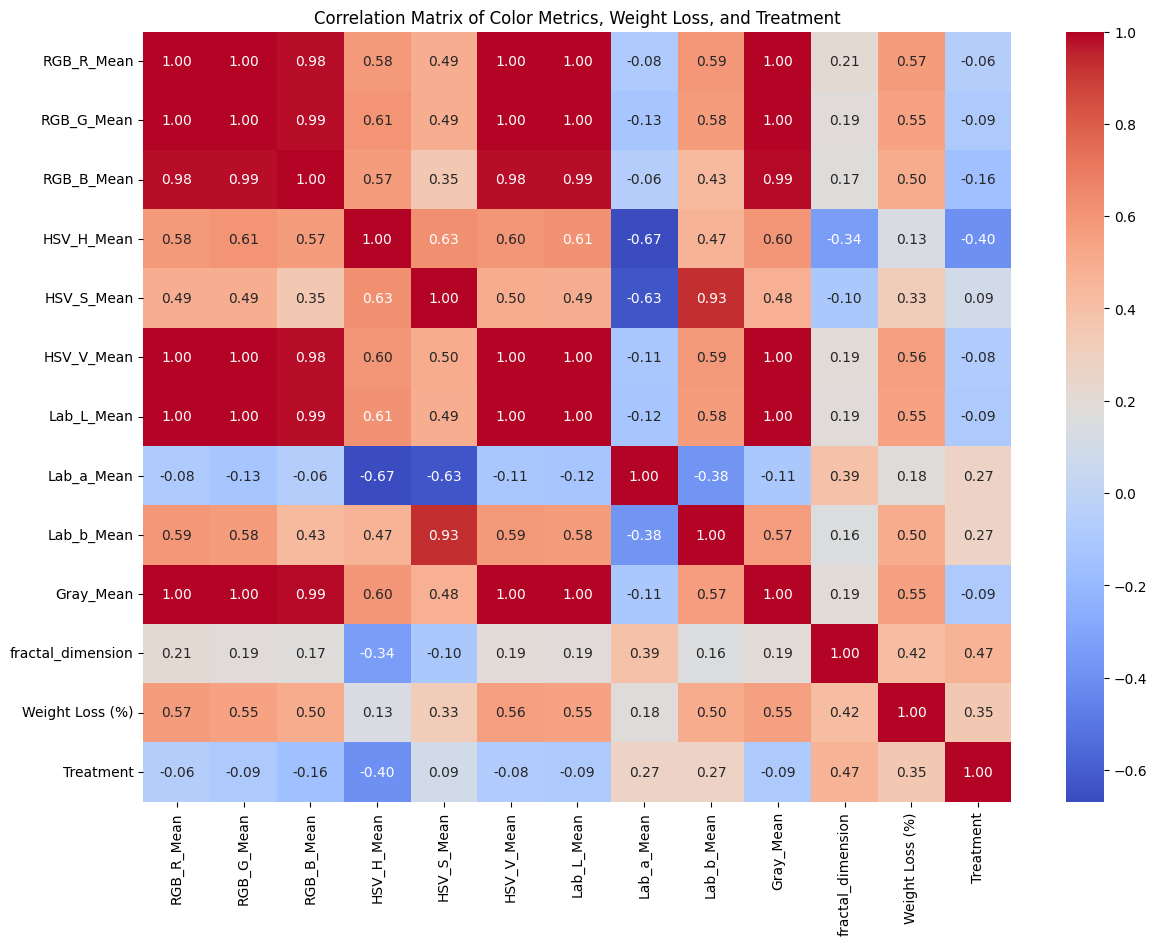

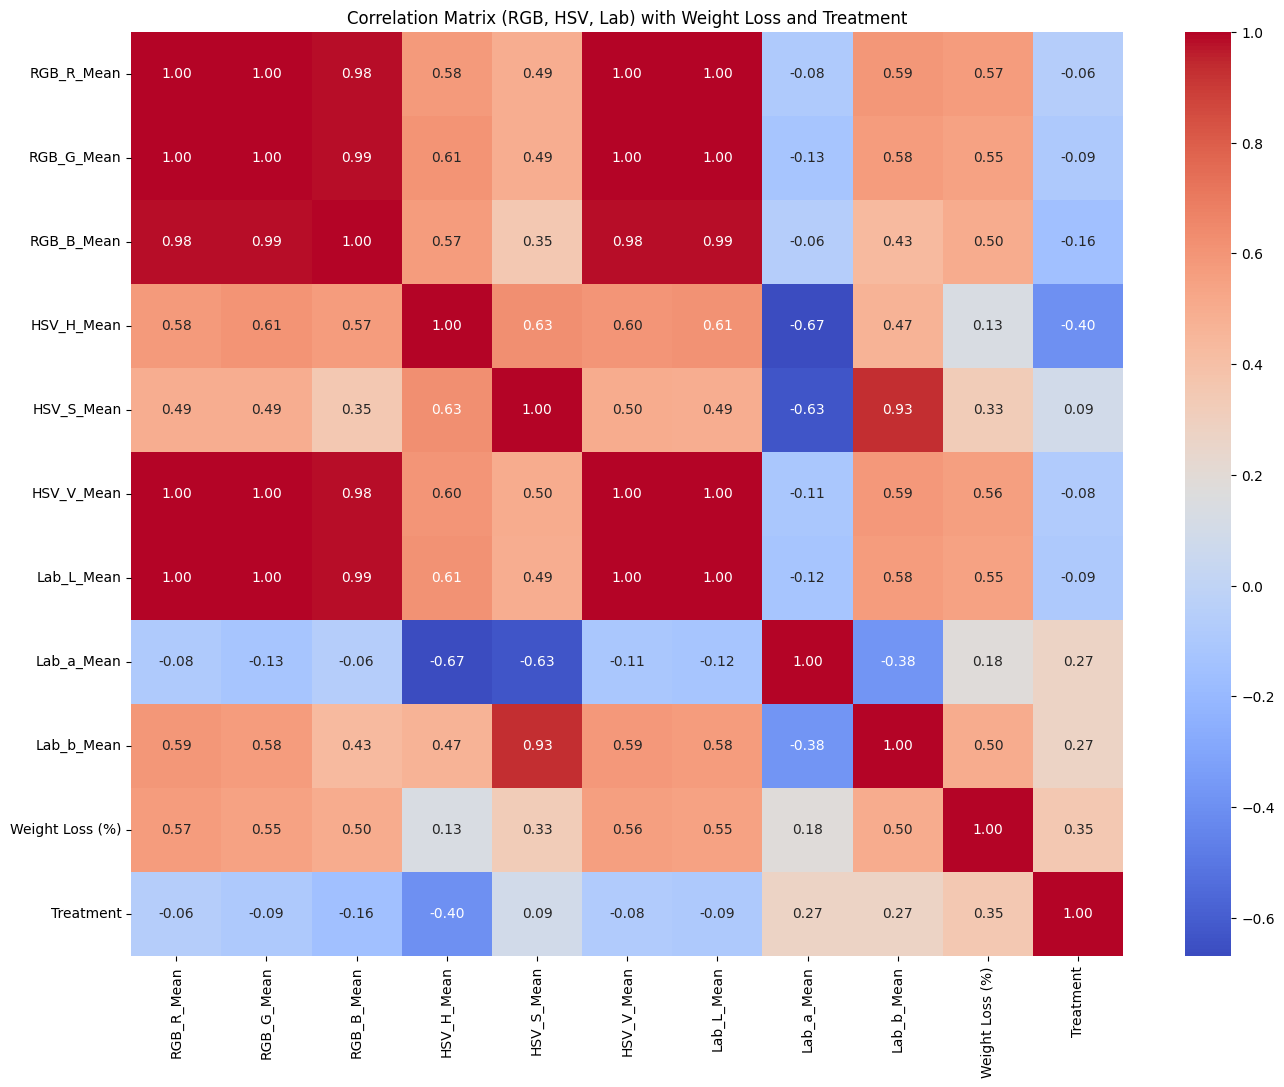

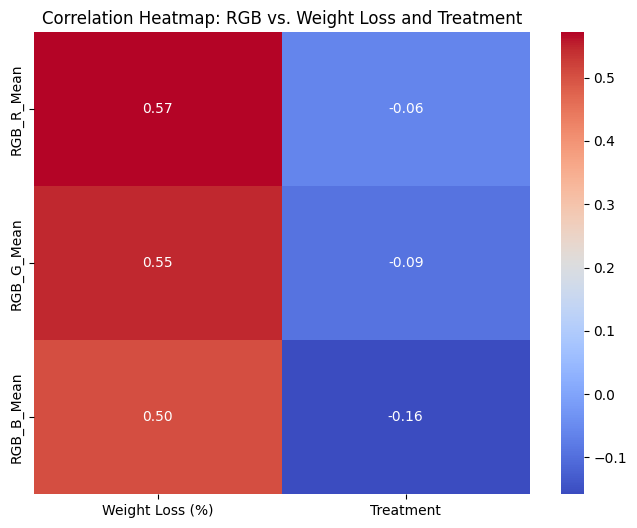

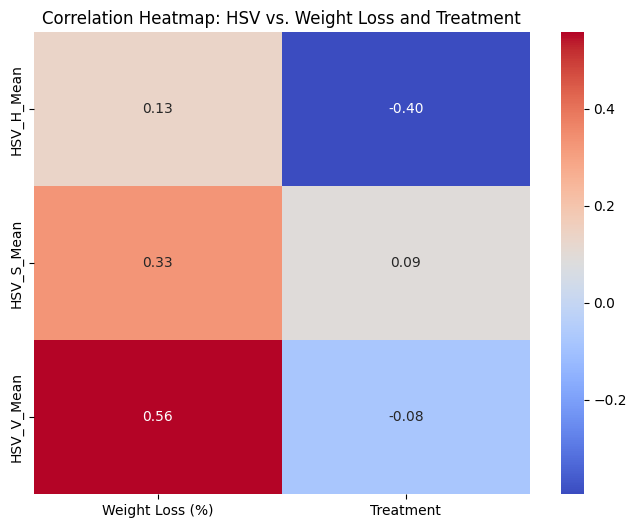

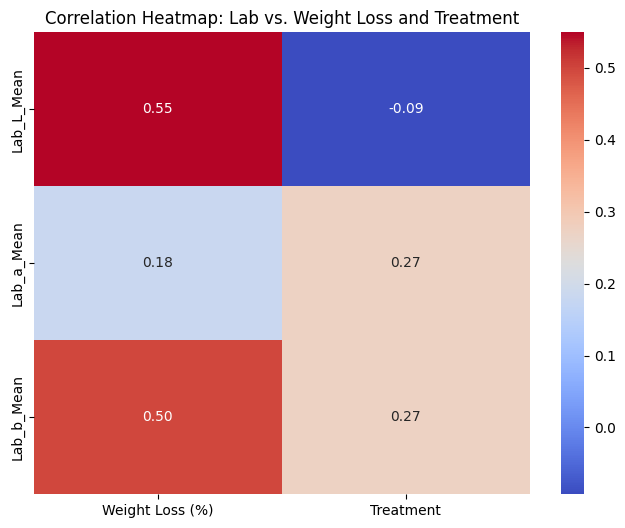

In [ ]:
# Compute correlations of color metrics, weight loss, and treatment
correlation_metrics = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean',
                       'HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean',
                       'Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean',
                       'Gray_Mean', 'fractal_dimension', 'Weight Loss (%)', 'Treatment']

# Calculate the correlation matrix for the selected metrics
correlation_matrix = combined_data[correlation_metrics].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Color Metrics, Weight Loss, and Treatment")
plt.show()
# Visualize the extracted correlations as heatmaps
# Extract metrics grouped by color spaces (RGB, HSV, Lab) along with weight loss and treatment
rgb_metrics = ['RGB_R_Mean', 'RGB_G_Mean', 'RGB_B_Mean']
hsv_metrics = ['HSV_H_Mean', 'HSV_S_Mean', 'HSV_V_Mean']
lab_metrics = ['Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean']
additional_metrics = ['Weight Loss (%)', 'Treatment']

# Combine selected metrics into groups
grouped_metrics = rgb_metrics + hsv_metrics + lab_metrics + additional_metrics

# Compute the correlation matrix for the selected groups
correlation_rgb_hsv_lab = combined_data[grouped_metrics].corr()
correlation_rgb = correlation_rgb_hsv_lab.loc[rgb_metrics, additional_metrics]
correlation_hsv = correlation_rgb_hsv_lab.loc[hsv_metrics, additional_metrics]
correlation_lab = correlation_rgb_hsv_lab.loc[lab_metrics, additional_metrics]

# Visualize the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_rgb_hsv_lab, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (RGB, HSV, Lab) with Weight Loss and Treatment")
plt.show()

# RGB Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_rgb, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap: RGB vs. Weight Loss and Treatment")
plt.show()

# HSV Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_hsv, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap: HSV vs. Weight Loss and Treatment")
plt.show()

# Lab Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_lab, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap: Lab vs. Weight Loss and Treatment")
plt.show()


## Visualize Heatmap for Combined Data

In [25]:
mean_weight_loss_by_treatment = weight_loss_data.groupby('Treatment').mean()
mean_weight_loss_by_treatment.drop(columns=['Rep'], inplace=True)
mean_weight_loss_by_treatment

,Percent Weight Loss Day 1,Percent Weight Loss Day 2,Percent Weight Loss Day 3,Percent Weight Loss Day 4,Percent Weight Loss Day 5,Percent Weight Loss Day 6,Percent Weight Loss Day 7,Percent Weight Loss Day 8
Treatment,,,,,,,,
5,3.21,5.16,6.05,7.00,7.48,9.03,9.68,10.46
10,3.71,4.80,6.12,7.18,8.57,9.95,10.75,11.97
15,4.29,5.18,7.37,8.53,10.92,11.82,15.67,18.22
20,5.28,6.25,8.93,10.44,13.58,24.59,NaN,NaN


In [81]:
# Select only numeric columns for the mean calculation
numeric_columns = color_data.select_dtypes(include=['float64', 'int64']).columns
mean_color_data_by_treatment = color_data.groupby('Treatment')[numeric_columns].mean()
mean_color_data_by_treatment

,RGB_R_Mean,RGB_R_StdDev,RGB_G_Mean,RGB_G_StdDev,RGB_B_Mean,RGB_B_StdDev,HSV_H_Mean,HSV_H_StdDev,HSV_S_Mean,HSV_S_StdDev,...,HSV_V_StdDev,Lab_L_Mean,Lab_L_StdDev,Lab_a_Mean,Lab_a_StdDev,Lab_b_Mean,Lab_b_StdDev,Gray_Mean,Gray_Std,fractal_dimension
Treatment,,,,,,,,,,,,,,,,,,,,,
5,107.227797,61.916532,114.843309,63.283388,92.759915,59.243062,19.166647,21.881809,43.603949,56.141645,...,63.302824,45.311781,24.847772,-6.598675,8.404211,10.849467,13.759020,110.049096,62.141356,1.920102
10,93.237202,60.061810,99.920650,64.197821,71.978826,56.589373,17.326470,21.052791,48.190631,62.032061,...,64.168248,39.341923,25.160038,-6.821251,8.816899,13.598628,17.026042,94.737410,61.510794,1.923908
15,99.567310,60.340266,103.028927,65.318410,69.010877,54.321678,15.708142,19.336728,51.565248,64.188502,...,65.189002,40.576469,25.477698,-6.113294,8.114603,16.562212,19.944746,98.116818,61.628497,1.930088
20,72.007740,68.249734,75.526846,73.482060,44.735139,47.761992,13.283835,17.734140,47.849780,65.020828,...,73.971218,29.726970,28.749568,-5.699517,8.169569,15.027374,19.959480,70.964988,68.384131,1.931164


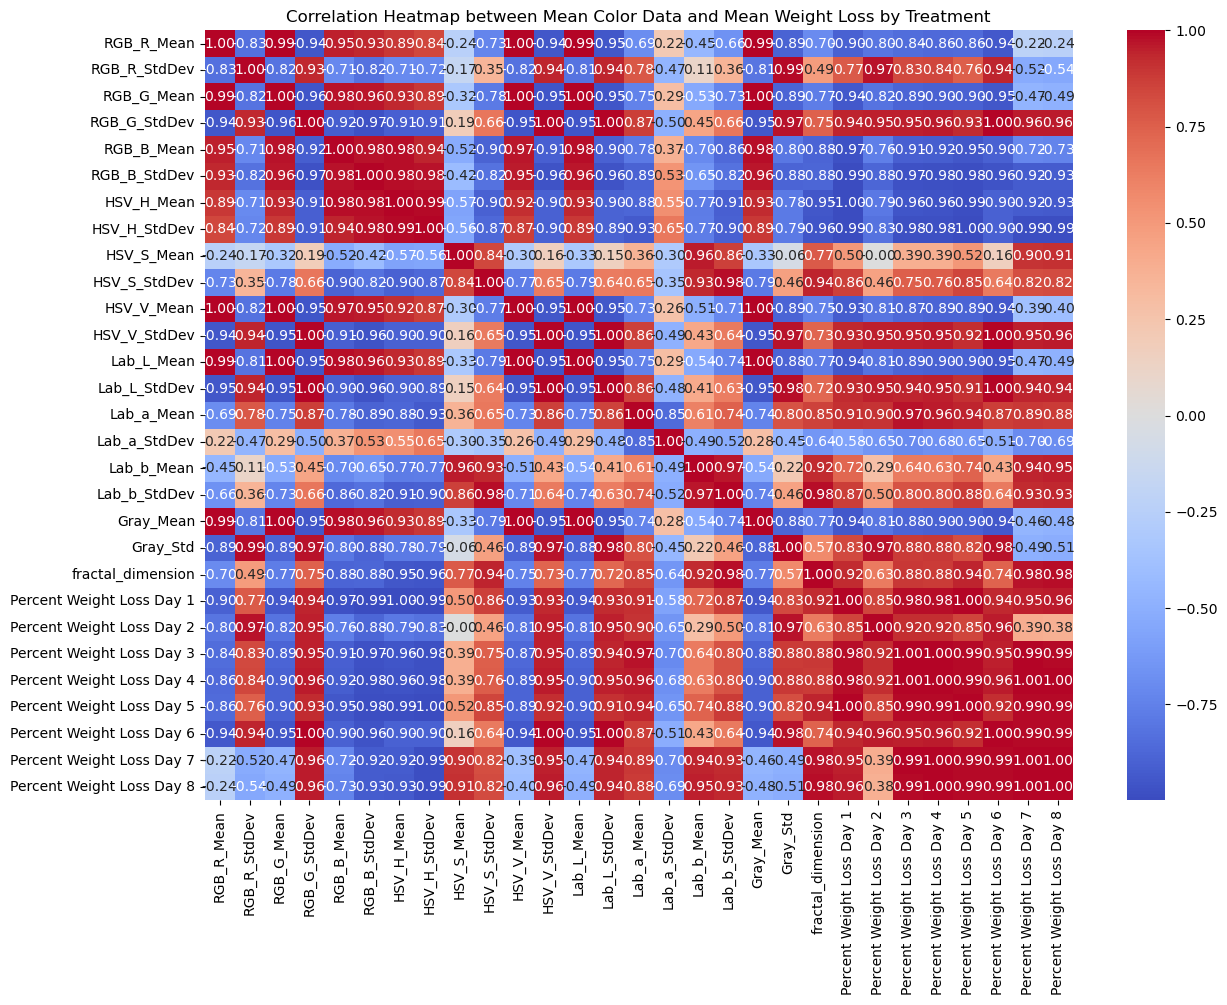

In [82]:
# Merge the two dataframes on the 'Treatment' column
merged_data = pd.merge(mean_color_data_by_treatment, mean_weight_loss_by_treatment, left_index=True, right_index=True)

# Compute the correlation matrix
correlation_matrix = merged_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap between Mean Color Data and Mean Weight Loss by Treatment")
plt.show()

In [ ]:
# Select only the relevant columns for correlation
relevant_columns = ['Percent Weight Loss Day 1', 'Percent Weight Loss Day 2', 'Percent Weight Loss Day 3',
                    'Percent Weight Loss Day 4', 'Percent Weight Loss Day 5', 'Percent Weight Loss Day 6',
                    'Percent Weight Loss Day 7', 'Percent Weight Loss Day 8'] + rgb_columns + hsv_columns + lab_columns

# Compute the correlation matrix for the selected columns
correlation_matrix_simple = merged_data[relevant_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_simple, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap between Percent Weight Loss and Color Metrics")
plt.show()

In [ ]:
# Plot the correlation heatmap between mean color data and mean weight loss by treatment
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap between Mean Color Data and Mean Weight Loss by Treatment")
plt.show()

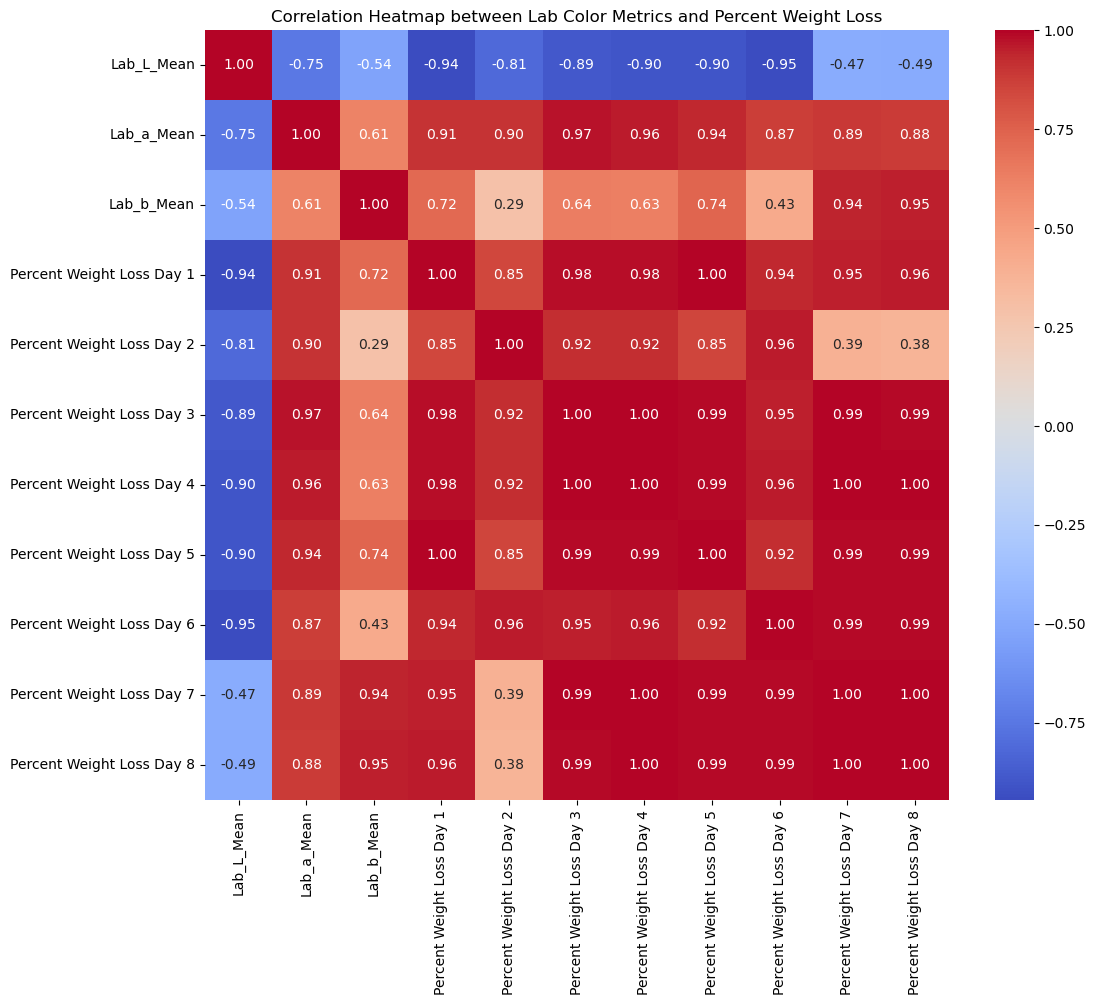

In [31]:
# Filter the correlation matrix to include only Lab color metrics and percent weight loss columns
lab_and_weightloss_columns = ['Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean',
                              'Percent Weight Loss Day 1', 'Percent Weight Loss Day 2', 
                              'Percent Weight Loss Day 3', 'Percent Weight Loss Day 4', 
                              'Percent Weight Loss Day 5', 'Percent Weight Loss Day 6', 
                              'Percent Weight Loss Day 7', 'Percent Weight Loss Day 8']

lab_weightloss_correlation = correlation_matrix.loc[lab_and_weightloss_columns, lab_and_weightloss_columns]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(lab_weightloss_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap between Lab Color Metrics and Percent Weight Loss")
plt.show()

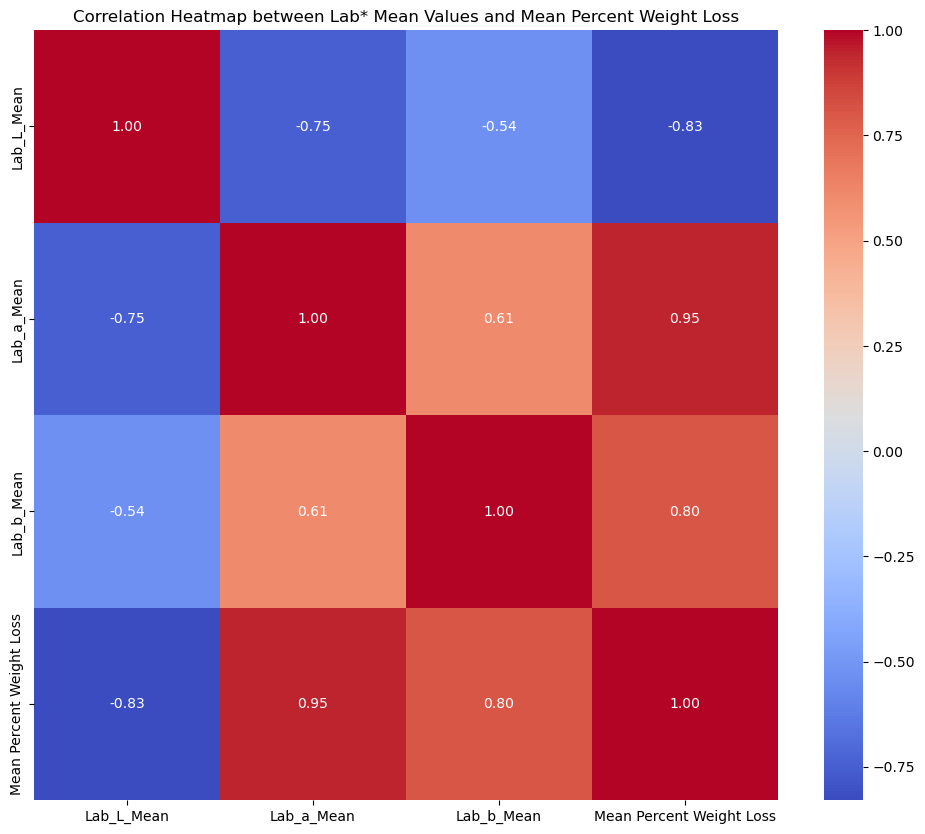

In [83]:
# Compute the mean percent weight loss for all days
merged_data['Mean Percent Weight Loss'] = merged_data[['Percent Weight Loss Day 1', 'Percent Weight Loss Day 2', 
                                                       'Percent Weight Loss Day 3', 'Percent Weight Loss Day 4', 
                                                       'Percent Weight Loss Day 5', 'Percent Weight Loss Day 6', 
                                                       'Percent Weight Loss Day 7', 'Percent Weight Loss Day 8']].mean(axis=1)

# Select only the relevant columns for correlation
lab_and_mean_weightloss_columns = ['Lab_L_Mean', 'Lab_a_Mean', 'Lab_b_Mean', 'Mean Percent Weight Loss']

# Compute the correlation matrix for the selected columns
lab_mean_weightloss_correlation = merged_data[lab_and_mean_weightloss_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(lab_mean_weightloss_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap between Lab* Mean Values and Mean Percent Weight Loss")
plt.show()

In [79]:
merged_data[lab_columns]

,Lab_L_Mean,Lab_a_Mean,Lab_b_Mean
Treatment,,,
5,45.311781,47.608363,54.450771
10,39.341923,47.521078,55.528874
15,40.576469,47.798708,56.691063
20,29.726970,47.960974,56.089166
